Facial Keypoint Detection


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [25]:
import numpy as np 
import pandas as pd 
import os
import missingno as msno 

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
%matplotlib inline 

checker = 0
for dirname, _, filenames in os.walk('drive/My Drive/facial_keypoints_data/'):
    for filename in filenames:
        if (os.path.join(dirname, filename) is not None): checker += 1
if checker == 4: print('All files are available')

All files are available


In [0]:
# test = pd.read_csv('drive/My Drive/facial_keypoints_data/test/test.csv')
# test.info()

# EDA

In [0]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')

In [27]:
#! TODO: check how variables behaves - quartiles, intervals
#  maybe there is a way to create challenger simply by putting coordinates as means/medians
training.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,2268.000000,2268.000000,2270.000000,2270.000000,2225.000000,2225.000000,2270.000000,2270.000000,2236.000000,2236.000000,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,3.057122,2.910368,3.485485,3.078134,3.986224,3.773744,3.209641,3.106869,3.622533,3.865772,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,3.980117,25.123828,17.888717,15.859361,32.206432,10.522325,6.921014,16.476000,3.826243,13.224453,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,20.585808,36.534382,54.515587,27.617244,77.673916,27.667948,37.552286,27.790607,13.562183,28.206046,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,24.237701,39.415051,57.946415,31.158830,81.590720,31.835621,40.917160,31.251664,17.999040,32.654768,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,61.428580,70.746797,79.787831,60.875896,94.269957,60.500298,76.582388,62.083177,58.418216,66.751329,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


How does y look like?

In [28]:
training.loc[:, training.columns != 'Image'].head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


How does X look like?

In [29]:
training['Image'].head(3)

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
Name: Image, dtype: object

### Missing values



Check how many NAs are in each column




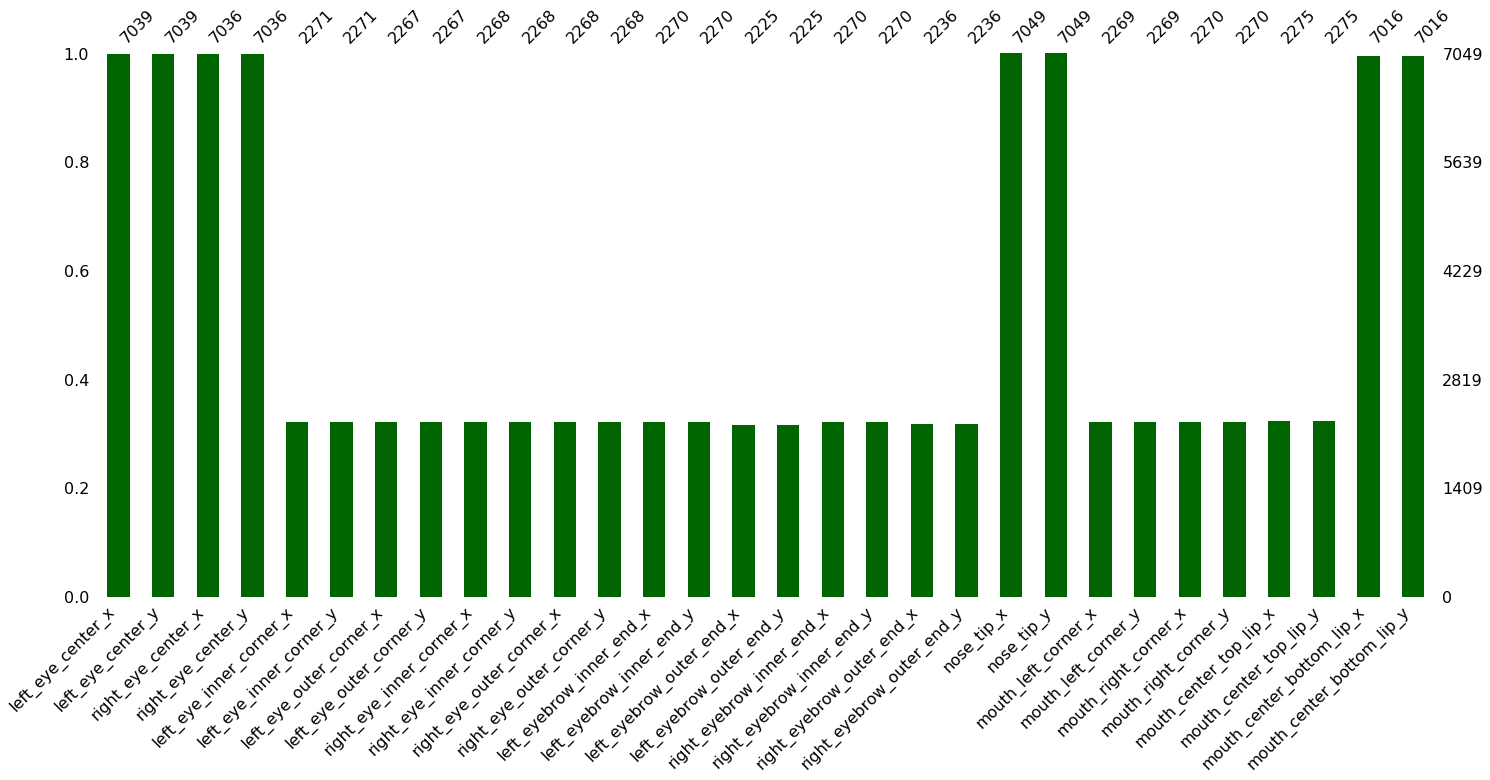

In [30]:
msno.bar(training[training.columns[:-1]], color='darkgreen') 

In [0]:
# check precisely how many NAs are in each colum
# training.isna().sum()

### Drop NAs



In [0]:
# drop NA rows
training = training.dropna()
#training.fillna(method = 'ffill',inplace = True)

In [32]:
training.shape, type(training)

((2140, 31), pandas.core.frame.DataFrame)

### Visualization


In [0]:
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

In [0]:
def get_image_and_dots(df, index):
    image = plt.imshow(df['Image'][index],cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(df.loc[index][i-1], df.loc[index][i], 'ro'))
        
    return image, l

def plot_faces(plot_dim = 6):
  fig = plt.figure(figsize=(12, 12))
  fig.subplots_adjust(
      left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

  for i in range(plot_dim*plot_dim):
      ax = fig.add_subplot(plot_dim, plot_dim, i + 1, xticks=[], yticks=[])
      get_image_and_dots(training, i)

  # plt.savefig('drive/My Drive/visualization.png', bbox_inches='tight')
  plt.show()

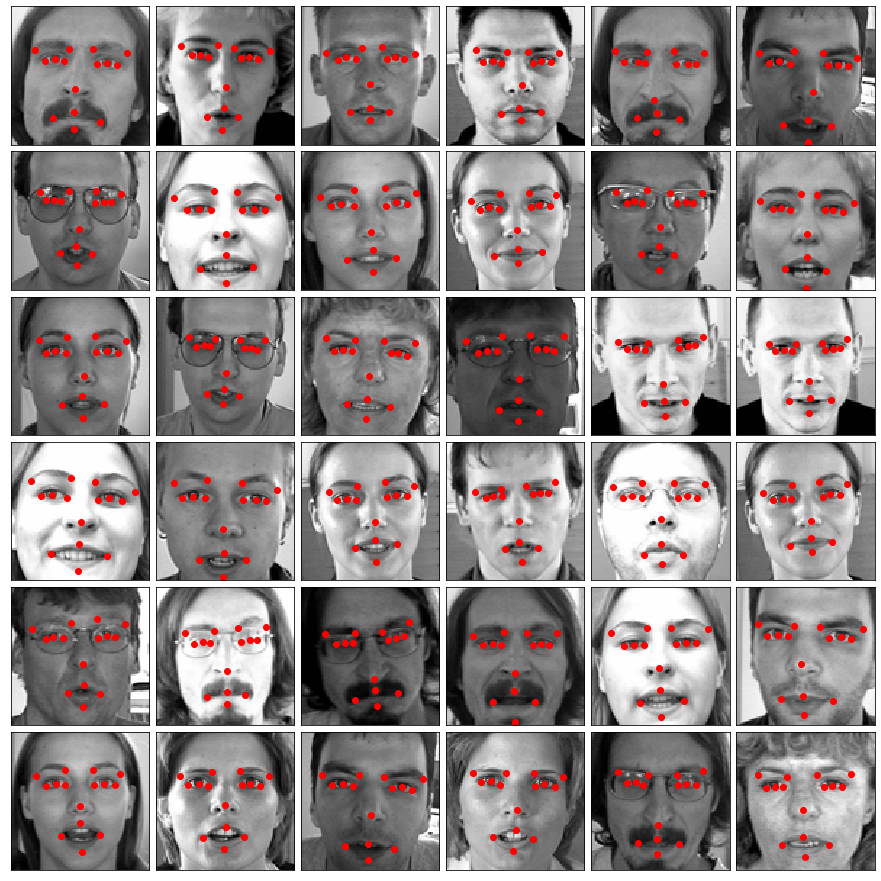

In [39]:
plot_faces(6)

Now we need to create X and Y matrixes. 

X's values are images (reshaped strings from datasource)

Y's are all features - 31 distinct features of human faces



In [0]:
X = np.asarray([training['Image']], dtype=np.uint8).reshape(training.shape[0],96,96,1)
y = training.drop(['Image'], axis=1)

In [41]:
print(f"X's shape: {X.shape}")
print(f"y's shape: {y.shape}")
print(f"X type: {type(X)}, Y type: {type(y)}")
yn = y.to_numpy()
print(f"yn type: {type(yn)}, yn shape: {yn.shape}")

X's shape: (2140, 96, 96, 1)
y's shape: (2140, 30)
X type: <class 'numpy.ndarray'>, Y type: <class 'pandas.core.frame.DataFrame'>
yn type: <class 'numpy.ndarray'>, yn shape: (2140, 30)


# Preprocessing



### Creating X and y

In [0]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training = training.dropna()

# scale pixel values to [0, 1]
X = np.vstack(training['Image'].values) / 255.
X = X.astype(np.float32)

y = training[training.columns[:-1]].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

### Train and test split

Now we need to create train and test sets for all models

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

# RMSE definition

In [0]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# **1st Model - Random Forest / XGBoost**

In [0]:
# random forest implementation

# **2nd Model - MLP**



In [45]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [46]:
model = Sequential([
  Dense(256, input_dim=X_train.shape[1], activation = 'relu'),
  Dropout(0.1),

  Dense(128, activation = 'relu'),
  Dropout(0.3),
  
  Dense(64, activation = 'relu'),
  Dense(30)
])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2359552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1950      
T

### MLP training

In [47]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model.compile(loss = root_mean_squared_error,
              optimizer = sgd)

hist_mlp = model.fit(X_train,
                     y_train,
                     epochs=500,
                     batch_size=128,
                     validation_split=0.1,
                     verbose=0)
print('Model trained')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Model trained


### Loss visualization

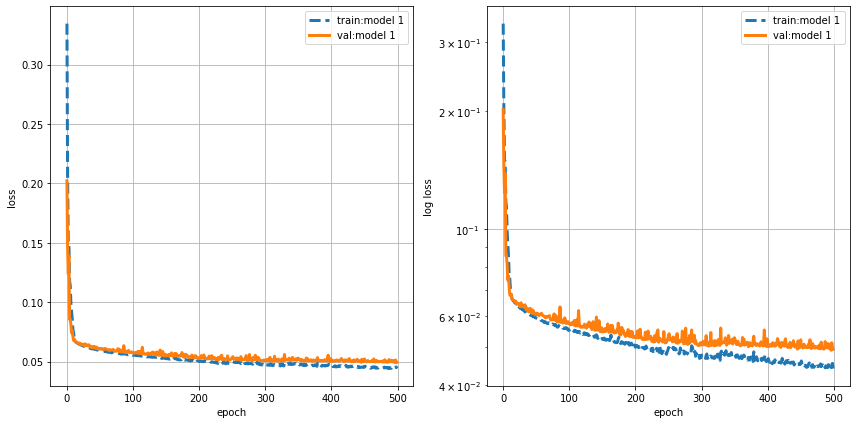

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")


plt.tight_layout()
# plt.savefig('drive/My Drive/MLP_loss.png', bbox_inches='tight')
plt.show()

In [50]:
loss_eval = model.evaluate(X_test, y_test, batch_size=128)
print('Test loss(RMSE):', loss_eval)
# print('Test accuracy:', acc)

321/321 [==============================] - 0s 68us/step
Test loss(RMSE): 0.04713146452359693


In [53]:
round(loss_eval * 48, 3)

2.262

#### TODO: compare test real with prediction on images

# **3rd Model - CNN**

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPool2D, LeakyReLU, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD

Preprocessing for CNN (reshaping from 1d vector)



In [0]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') < 0.001):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [57]:
model = Sequential([
  Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Conv2D(32, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),
  
  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  # BatchNormalization(),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(256, (3,3),padding='same',use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Conv2D(256, (3,3),padding='same',use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(512, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Conv2D(512, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Flatten(),
  Dense(512,activation='relu'),
  Dropout(0.1),
  Dense(30)
])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model.compile(loss = root_mean_squared_error,
              optimizer = sgd)

In [59]:
hist_cnn = model.fit(X_train,
                     y_train,
                     epochs=500,
                     batch_size=128,
                     validation_split=0.1,
                     verbose = 1,
                     callbacks=[callbacks]
                     )

Train on 1637 samples, validate on 182 samples
Epoch 1/500
1637/1637 [==============================] - 8s 5ms/sample - loss: 0.7009 - val_loss: 0.3754
Epoch 2/500
1637/1637 [==============================] - 1s 719us/sample - loss: 0.2068 - val_loss: 0.3344
Epoch 3/500
1637/1637 [==============================] - 1s 720us/sample - loss: 0.1563 - val_loss: 0.3062
Epoch 4/500
1637/1637 [==============================] - 1s 719us/sample - loss: 0.1132 - val_loss: 0.2959
Epoch 5/500
1637/1637 [==============================] - 1s 722us/sample - loss: 0.1006 - val_loss: 0.3031
Epoch 6/500
1637/1637 [==============================] - 1s 719us/sample - loss: 0.0952 - val_loss: 0.3165
Epoch 7/500
1637/1637 [==============================] - 1s 721us/sample - loss: 0.0915 - val_loss: 0.3380
Epoch 8/500
1637/1637 [==============================] - 1s 720us/sample - loss: 0.0880 - val_loss: 0.3596
Epoch 9/500
1637/1637 [==============================] - 1s 723us/sample - loss: 0.0911 - val_loss:

### Loss visualization

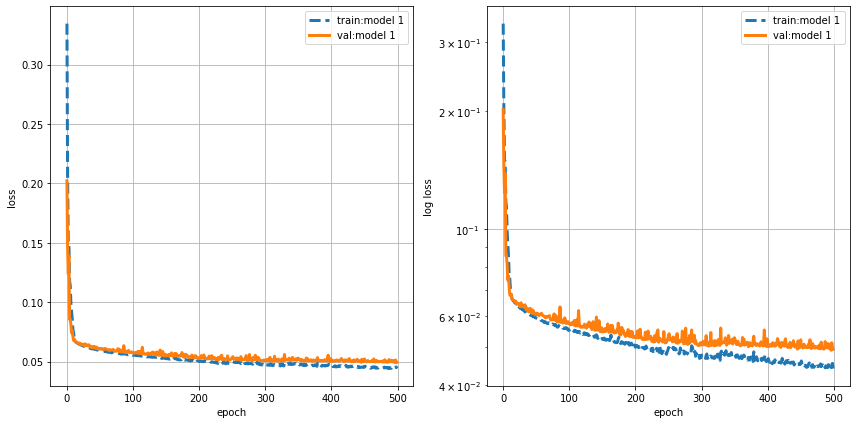

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
# plt.savefig('drive/My Drive/CNN_loss.png', bbox_inches='tight')
plt.show()

### Evaluation

In [61]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', round(score*48, 3))

Test RMSE: 0.04306092312867025
Rescaled RMSE: 2.067


In [0]:
y_eval = model.predict(X_test)

### Plotting predicted and real

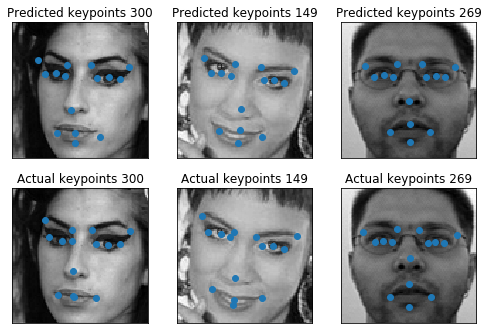

In [64]:
def plot_sample(X,y,axs):
    '''
    kaggle picture is 96 by 96
    y is rescaled to range between -1 and 1
    '''
    
    axs.imshow(X.reshape(96,96),cmap="gray")
    axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
picture_id = [300,149,269]

for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_eval[ipic],ax)
    ax.set_title("Predicted keypoints "+ str(ipic))
    count += 1


for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_test[ipic],ax)
    ax.set_title("Actual keypoints "+ str(ipic))
    count += 1

plt.tight_layout()
# plt.savefig('drive/My Drive/CNN_faces_test_eval.png', bbox_inches='tight')
plt.show()

In [0]:
model.save('cnn_rmse_2_03.h5')

# **4th Model - CNN with transfer learning**

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPool2D, LeakyReLU, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD

## First CNN (with 8 coordinates)

### Preprocessing for CNN with few features

In [0]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')
# training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training.shape

(7049, 31)

Subset of all features (no NAs):


In [0]:
training_all_features = training.dropna()
training_all_features.shape

(2140, 31)

Subset with 8 features and images:

In [0]:
df_all = training.merge(training_all_features.drop_duplicates(), on=['Image'], 
                   how='left', indicator=True)
training_few_features = df_all[df_all['_merge'] == 'left_only'].iloc[:,0:31]
training_few_features = training_few_features.dropna(axis=1, thresh=len(training_few_features) - 34)
training_few_features.shape

(4908, 9)

Separating test set (for final model) from training_all_features

In [0]:
training_all_features = shuffle(training_all_features, random_state=666)
test_final = training_all_features.head(300)
training_all_features = training_all_features.tail(len(training_all_features) - 300)
training_all_features.shape

(1840, 31)

Combining training_few_features with training_all_features

In [0]:
print(training_few_features.shape)
print(training_all_features.shape)

(4908, 9)
(1840, 31)


In [0]:
training_few_features.columns = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

In [0]:
training_all_features[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']].shape

(1840, 9)

In [0]:
training_cnn = pd.concat([training_few_features, training_all_features[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']]])

In [0]:
training_cnn.shape

(6748, 9)

### Train/test split for CNN with few features

In [0]:
# training_cnn

In [0]:
training_cnn['Image'] = training_cnn['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training_cnn = training_cnn.dropna()
# scale pixel values to [0, 1]
X = np.vstack(training_cnn['Image'].values) / 255.
X = X.astype(np.float32)

y = training_cnn[training_cnn.columns[:-1]].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

In [0]:
training_cnn.isna().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
nose_tip_x                   0
nose_tip_y                   0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

In [0]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)
print(X_train.shape)
print(X_test.shape)

(5694, 96, 96, 1)
(1005, 96, 96, 1)


### CNN with few features training

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') < 0.04):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [0]:
model = Sequential([
  Conv2D(32,(3, 3), activation='relu', input_shape = (96, 96, 1)),
  BatchNormalization(),
  MaxPool2D(2, 2),

  Conv2D(64, (3,3), activation='relu'),
  MaxPool2D(2,2),
  Dropout(0.1),

  Conv2D(128, (3,3), activation='relu'),
  BatchNormalization(),
  MaxPool2D(2,2),
  Dropout(0.2),

  Conv2D(128, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  # BatchNormalization(),
  # MaxPool2D(pool_size=(2, 2)),

  # Conv2D(128, (3,3), padding='same', use_bias=False),
  # LeakyReLU(alpha = 0.1),
  # BatchNormalization(),
  # MaxPool2D(pool_size=(2, 2)),

  Flatten(),
  Dense(256,activation='relu'),
  Dropout(0.1),
  Dense(8)
])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model.compile(loss = root_mean_squared_error,
              optimizer = sgd)

In [0]:
hist_cnn_ff = model.fit(X_train,
                        y_train,
                        epochs=500,
                        batch_size=128,
                        validation_split=0.1,
                        verbose = 1,
                        callbacks=[callbacks]
                     )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5124 samples, validate on 570 samples
Epoch 1/500
5124/5124 [==============================] - 18s 4ms/sample - loss: 0.3031 - val_loss: 0.2479
Epoch 2/500
5124/5124 [==============================] - 2s 437us/sample - loss: 0.1008 - val_loss: 0.1688
Epoch 3/500
5124/5124 [==============================] - 2s 433us/sample - loss: 0.0895 - val_loss: 0.1245
Epoch 4/500
5124/5124 [==============================] - 2s 425us/sample - loss: 0.0852 - val_loss: 0.1186
Epoch 5/500
5124/5124 [==============================] - 2s 433us/sample - loss: 0.0825 - val_loss: 0.0957
Epoch 6/500
5124/5124 [==============================] - 2s 429us/sample - loss: 0.0794 - val_loss: 0.0937
Epoch 7/500
5124/5124 [==============================] - 2s 436us/sample - loss: 0.0765 - val_loss: 0.0948
Epoch 8/500
5124/5124 [==============================] - 2s 443us/sample - loss: 0.0742 - val_loss: 0.0872
Epoc

#### Loss visualization

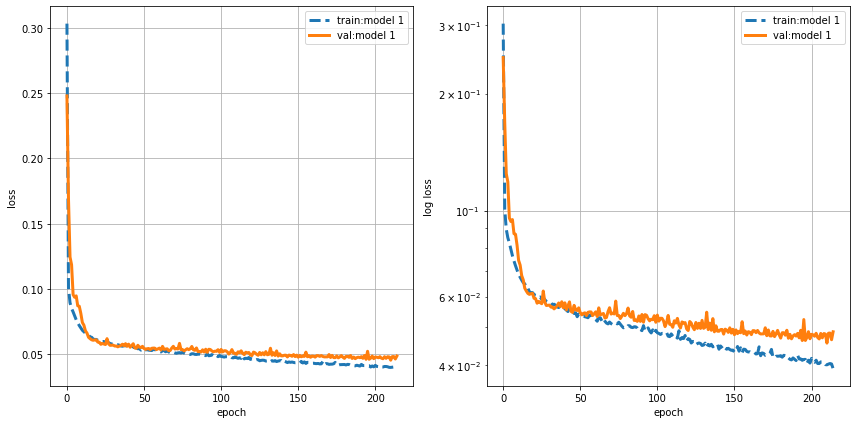

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_cnn_ff.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_cnn_ff.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
plt.show()

#### Evaluation

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', score*48)

InvalidArgumentError: ignored

#### Saving weights

In [0]:
model.save('drive/My Drive/cnn_ff_rmse_2_43.h5')

#### Preparing for transfer learning

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       7

In [0]:
last_layer = model.get_layer('leaky_re_lu')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 10, 10, 128)


In [0]:
x =  Conv2D(128, (3,3), padding='same', activation='relu')(last_output)
x =  MaxPool2D(2,2)(x)
x =  Dropout(0.1)(x)

x =  Conv2D(128, (3,3), padding='same', activation='relu')(x)
x =  BatchNormalization()(x)
x =  MaxPool2D(2,2)(x)
x =  Dropout(0.2)(x)

x =  Conv2D(128, (3,3), padding='same', use_bias=False)(x)
x =  LeakyReLU(alpha = 0.1)(x)
x =  BatchNormalization()(x)
x =  MaxPool2D(pool_size=(2, 2))(x)

# x =  Conv2D(128, (3,3), padding='same', use_bias=False)(x)
# x =  LeakyReLU(alpha = 0.1)(x)
# # x =  BatchNormalization()(x)
# x =  MaxPool2D(pool_size=(2, 2))(x)

x =  Flatten()(x)
x =  Dense(512, activation='relu')(x)
x =  Dropout(0.2)(x)                  

x =  Dense(30, activation='sigmoid')(x)           


In [0]:
model_tf = Model( model.input, x) 

# model_tf.compile(optimizer = RMSprop(lr=0.0001), 
#               loss = 'binary_crossentropy', 
#               metrics = ['acc'])

In [0]:
model_tf.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0   

#### Preprocessing for all features

In [0]:
training_cnn['Image'] = training_cnn['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training_cnn = training_cnn.dropna()
# scale pixel values to [0, 1]
X = np.vstack(training_cnn['Image'].values) / 255.
X = X.astype(np.float32)

y = training_cnn[training_cnn.columns[:-1]].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

In [0]:
test_final['Image']
# training_all_features.shape

67      186 186 183 155 105 85 63 57 64 64 66 59 59 65...
2119    85 76 66 63 57 52 49 48 50 55 59 57 55 57 57 6...
61      233 199 175 148 116 83 106 140 139 108 82 65 5...
2242    82 84 53 13 8 9 22 17 16 16 12 11 16 19 21 39 ...
238     196 196 196 195 195 194 196 196 194 194 193 19...
                              ...                        
1223    51 34 31 30 31 37 37 43 39 39 44 37 42 48 44 4...
1961    118 149 161 164 133 80 50 44 54 44 38 56 58 66...
473     76 82 87 102 111 111 110 109 110 133 146 144 1...
207     185 184 187 187 187 189 191 192 191 202 164 42...
1449    158 86 54 40 39 39 47 47 38 33 30 26 25 26 27 ...
Name: Image, Length: 300, dtype: object

In [0]:
test_final['Image'] = test_final['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training_all_features['Image'] = training_all_features['Image'].apply(lambda x: np.fromstring(x, sep=' '))

# TEST SET
# test_final = training_all_features.head(300)
X_test = np.vstack(test_final['Image'].values) / 255.
X_test = X_test.astype(np.float32)

y_test = test_final[test_final.columns[:-1]].values
y_test = (y_test - 48) / 48  # scale target coordinates to [-1, 1]
y_test = y_test.astype(np.float32)

# TRAIN SET
# training_all_features = training_all_features.tail(len(training_all_features) - 300)
X_train = np.vstack(training_all_features['Image'].values) / 255.
X_train = X_train.astype(np.float32)

y_train = training_all_features[training_all_features.columns[:-1]].values
y_train = (y_train - 48) / 48  # scale target coordinates to [-1, 1]
y_train = y_train.astype(np.float32)

In [0]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)
print(X_train.shape)
print(X_test.shape)

(1840, 96, 96, 1)
(300, 96, 96, 1)


In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model_tf.compile(loss = root_mean_squared_error,
              optimizer = sgd)

In [0]:
hist_cnn_af = model_tf.fit(X_train,
                        y_train,
                        epochs=500,
                        batch_size=128,
                        validation_split=0.1,
                        verbose = 1,
                        callbacks=[callbacks]
                     )

Train on 1656 samples, validate on 184 samples
Epoch 1/500
1656/1656 [==============================] - 2s 1ms/sample - loss: 0.5848 - val_loss: 0.4739
Epoch 2/500
1656/1656 [==============================] - 1s 471us/sample - loss: 0.3431 - val_loss: 0.2745
Epoch 3/500
1656/1656 [==============================] - 1s 469us/sample - loss: 0.2896 - val_loss: 0.2694
Epoch 4/500
1656/1656 [==============================] - 1s 464us/sample - loss: 0.2861 - val_loss: 0.2675
Epoch 5/500
1656/1656 [==============================] - 1s 461us/sample - loss: 0.2805 - val_loss: 0.2708
Epoch 6/500
1656/1656 [==============================] - 1s 466us/sample - loss: 0.2784 - val_loss: 0.2724
Epoch 7/500
1656/1656 [==============================] - 1s 467us/sample - loss: 0.2775 - val_loss: 0.2714
Epoch 8/500
1656/1656 [==============================] - 1s 470us/sample - loss: 0.2766 - val_loss: 0.2704
Epoch 9/500
1656/1656 [==============================] - 1s 470us/sample - loss: 0.2760 - val_loss:

In [0]:
score = model_tf.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', score*48)

Test RMSE: 0.2619571014245351
Rescaled RMSE: 12.573940868377685
